In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm


import os
import pickle

import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


torch.set_default_dtype(torch.float32)

####################################################################

Device = 'cpu'


output_file = 'Result/L.DKMGP_21_result.csv'
mcmc_dir = 'Result/L.DKMGP_21_mcmc_result'
if not os.path.exists(mcmc_dir):
    os.makedirs(mcmc_dir)

if not os.path.exists(output_file):
    with open(output_file, 'w') as f:
        f.write('Iteration,test_preds,estimated_params\n')

row_idx = 0

In [2]:

input_point = test_y_21[row_idx, :]

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    feature_extractor_class = FeatureE.FeatureExtractor_4, covar_type = 'RQ', 
    lr=0.05, num_iterations=5000, patience=10, device = Device)

preds_tmp = Prediction.preds_for_one_model(
    MultitaskGP_models, MultitaskGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)
    ).cpu().detach().numpy()



In [3]:
bounds = bound.get_bounds(local_train_x)

estimated_params_tmp, _ = Estimation.multi_start_estimation(
    MultitaskGP_models, MultitaskGP_likelihoods, row_idx, test_y_21, bounds,
    Estimation.estimate_params_for_one_model_Adam, num_starts=4, num_iterations=1000, lr=0.01,
    patience=10, attraction_threshold=0.1, repulsion_strength=0.1, device=Device
)

In [4]:
def preds_distribution(model, likelihood, xxx):
    model.eval()
    likelihood.eval()
    preds = likelihood(model(xxx))
    return preds

In [5]:
def preds_distribution_fast_pred_var(model, likelihood, xxx):
    model.eval()
    likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        preds = likelihood(model(xxx))
    return preds

In [6]:
mcmc_result_Uniform_fast_pred_var = Estimation.run_mcmc_Uniform(
    preds_distribution_fast_pred_var, MultitaskGP_models, MultitaskGP_likelihoods, 
    row_idx, test_y_21, bounds, 
    num_sampling=1200, warmup_step=300, num_chains=1, device=Device
)
posterior_samples_Uniform_fast_pred_var = mcmc_result_Uniform_fast_pred_var.get_samples()


Sample: 100%|██████████| 1500/1500 [09:43,  2.57it/s, step size=5.18e-01, acc. prob=0.898]


In [7]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(
    preds_distribution, MultitaskGP_models, MultitaskGP_likelihoods, 
    row_idx, test_y_21, bounds, 
    num_sampling=1200, warmup_step=300, num_chains=1, device=Device
)
posterior_samples_Uniform_nograd = mcmc_result_Uniform.get_samples()


Sample: 100%|██████████| 1500/1500 [1:06:57,  2.68s/it, step size=2.87e-01, acc. prob=0.852]


d:\anaconda3\envs\FGPyT\lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


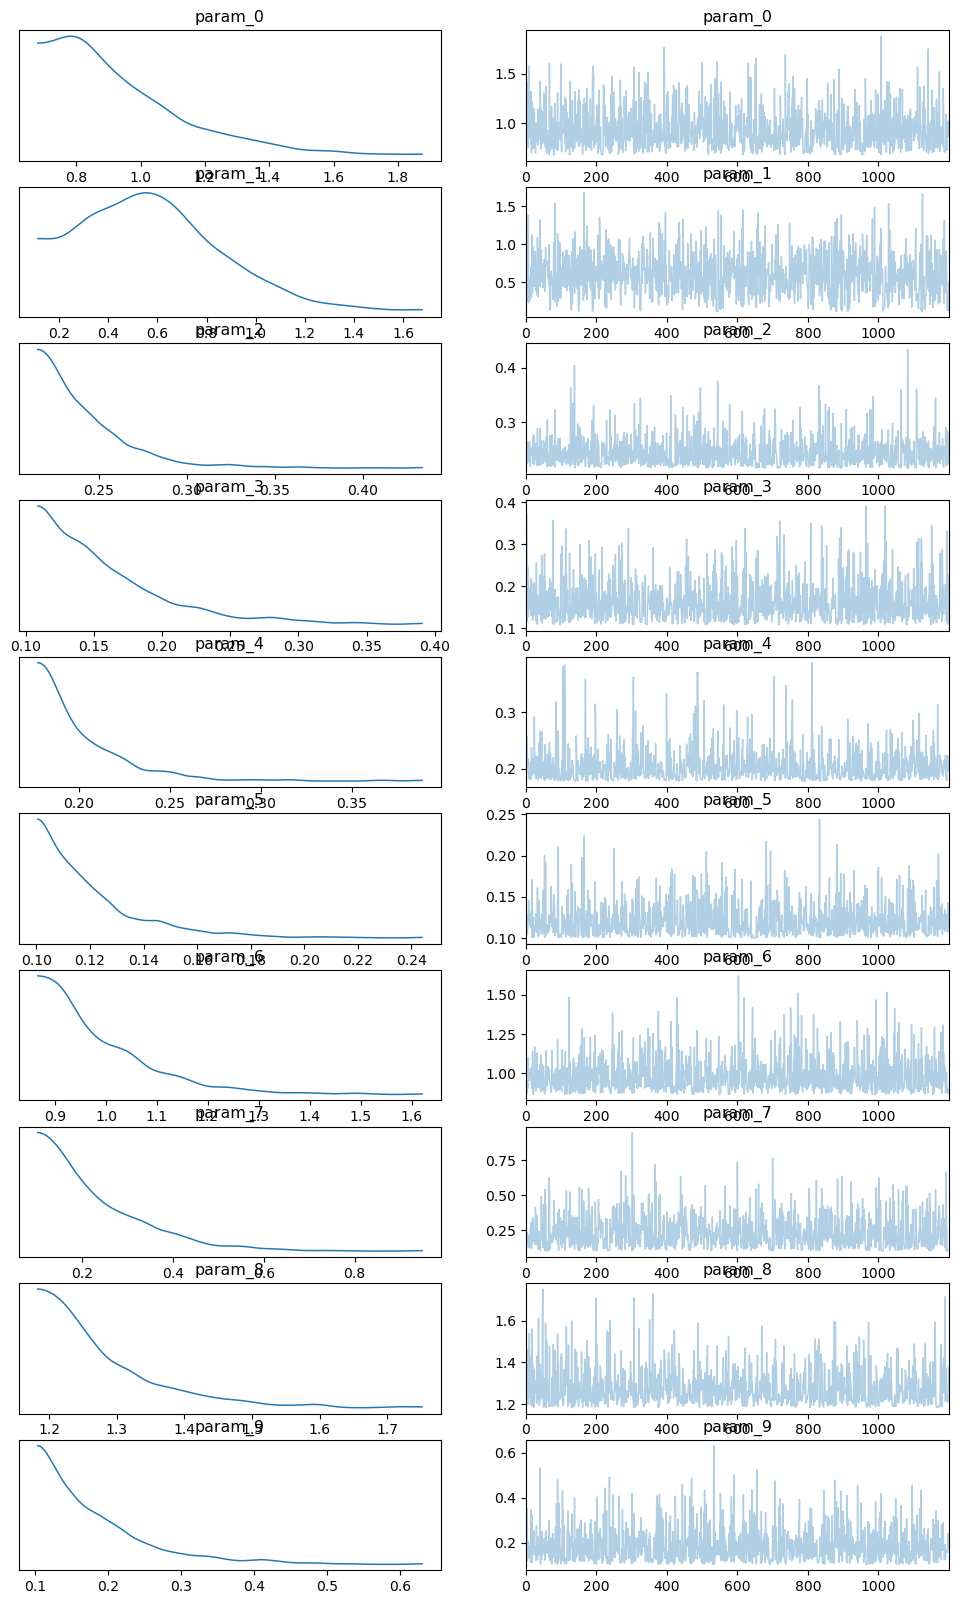

arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0  0.931  0.202     0.679      1.338      0.006    0.004     776.0   
param_1  0.580  0.280     0.111      1.082      0.008    0.006     789.0   
param_2  0.242  0.027     0.215      0.292      0.001    0.000     874.0   
param_3  0.161  0.049     0.109      0.267      0.001    0.001     939.0   
param_4  0.204  0.029     0.177      0.257      0.001    0.001     685.0   
param_5  0.121  0.020     0.100      0.162      0.001    0.000     593.0   
param_6  0.986  0.111     0.865      1.211      0.003    0.002     942.0   
param_7  0.229  0.115     0.102      0.453      0.003    0.002     648.0   
param_8  1.277  0.090     1.183      1.461      0.003    0.002     727.0   
param_9  0.184  0.077     0.104      0.346      0.002    0.001     959.0   

         ess_tail  r_hat  
param_0     457.0    NaN  
param_1     414.0    NaN  
param_2     380.0    NaN  
param_3     534.0    NaN  
param_4     512.0    NaN  
p

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

idata = az.from_pyro(mcmc_result_Uniform)
az.plot_trace(idata)
plt.show()


summary = az.summary(idata, hdi_prob=0.95)
print(summary)

In [9]:
test_x[row_idx]

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

In [8]:
estimated_params_tmp

array([3.7074757, 4.7847986, 1.4568138, 4.7088513, 2.8828466, 0.5996813,
       3.0054455, 3.5438683, 4.732345 , 1.8865539], dtype=float32)